In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

## Training of GNN model (loss vs iteration)

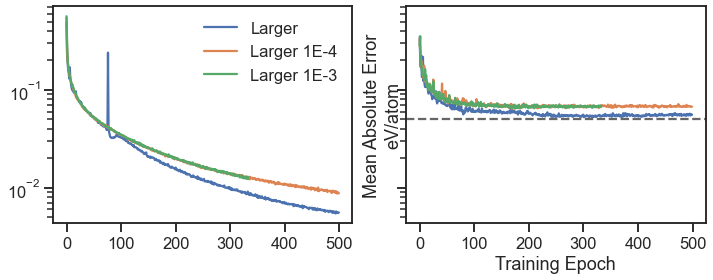

In [3]:
fig, axmatrix = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,4))

log = pd.read_csv('trained_model_mp/log.csv')
log2 = pd.read_csv('trained_model_mp_nodropout/log.csv')
log3 = pd.read_csv('trained_model_mp_nodropout_large/log.csv')
log34 = pd.read_csv('trained_model_mp_nodropout_large_1E4/log.csv')
log33 = pd.read_csv('trained_model_mp_nodropout_large_1E3/log.csv')
log4 = pd.read_csv('trained_model_mp_nodropout_xlarge/log.csv')
log5 = pd.read_csv('trained_model_mp_nodropout_xlarge2/log.csv')


# axmatrix[0].semilogy(log.epoch, log.loss, label='w Dropout')
# axmatrix[1].semilogy(log.epoch, log.val_loss)

# axmatrix[0].semilogy(log2.epoch, log2.loss, label='w/o Dropout')
# axmatrix[1].semilogy(log2.epoch, log2.val_loss)

axmatrix[0].semilogy(log3.epoch, log3.loss, label='Larger')
axmatrix[1].semilogy(log3.epoch, log3.val_loss)


axmatrix[0].semilogy(log34.epoch, log34.loss, label='Larger 1E-4')
axmatrix[1].semilogy(log34.epoch, log34.val_loss)

axmatrix[0].semilogy(log33.epoch, log33.loss, label='Larger 1E-3')
axmatrix[1].semilogy(log33.epoch, log33.val_loss)

# axmatrix[0].semilogy(log4.epoch, log4.loss, label='xlarge')
# axmatrix[1].semilogy(log4.epoch, log4.val_loss)

# axmatrix[0].semilogy(log5.epoch, log5.loss, label='xlarge2')
# axmatrix[1].semilogy(log5.epoch, log5.val_loss)

plt.axhline(.05, ls='--', color='.4')
axmatrix[0].legend()
# plt.ylim([0.05, 0.2])

plt.ylabel('Mean Absolute Error\neV/atom')
plt.xlabel('Training Epoch')
plt.tight_layout()
#plt.savefig('figs/training_curve.svg')

## Load the model and preprocessor

In [3]:
import pickle
import tensorflow as tf
import nfp
from nfp_extensions import RBFExpansion, CifPreprocessor

# Initialize the preprocessor class.
preprocessor = CifPreprocessor(num_neighbors=12)
preprocessor.from_json('tfrecords_mp/preprocessor.json')
    
model = tf.keras.models.load_model(
    'trained_model_mp_nodropout_large/best_model.hdf5',
    custom_objects={**nfp.custom_objects, **{'RBFExpansion': RBFExpansion}})

## Load the test data and convert to model inputs (using pymatgen)

In [4]:
from pymatgen.core.structure import Structure
from tqdm import tqdm

In [46]:
test = pd.read_csv('tfrecords_mp/test.csv.gz')

cif_file = lambda x: '/projects/rlmolecule/pstjohn/materials_project_cifs/{}.cif.gz'.format(x)
get_crystal = lambda x: Structure.from_file(cif_file(x), primitive=True)

Example crystal parsing

In [64]:
get_crystal(test.mpid.iloc[4])

Structure Summary
Lattice
    abc : 3.728893 3.728893 3.728893
 angles : 90.0 90.0 90.0
 volume : 51.848925970517726
      A : 3.728893 0.0 2.2832884384064856e-16
      B : 5.996517291520662e-16 3.728893 2.2832884384064856e-16
      C : 0.0 0.0 3.728893
PeriodicSite: Sc (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Cu (1.8644, 1.8644, 1.8644) [0.5000, 0.5000, 0.5000]
PeriodicSite: O (1.8644, 1.8644, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: O (1.8644, 0.0000, 1.8644) [0.5000, 0.0000, 0.5000]
PeriodicSite: O (0.0000, 1.8644, 1.8644) [0.0000, 0.5000, 0.5000]

Create a tf.data pipeline

In [7]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(get_crystal(mpid), train=False)
             for mpid in tqdm(test.mpid)),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128,
                  padded_shapes=preprocessor.padded_shapes(max_sites=256, max_bonds=2048),
                  padding_values=preprocessor.padding_values)

## Predict the test crystals.
The slow step here is definitely loading the CIF files and creating the primitive cell

In [8]:
predictions = model.predict(test_dataset)

  1%|          | 6/500 [00:00<00:24, 20.13it/s]/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/pymatgen/io/cif.py:1122: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))
100%|██████████| 500/500 [00:22<00:00, 22.29it/s]


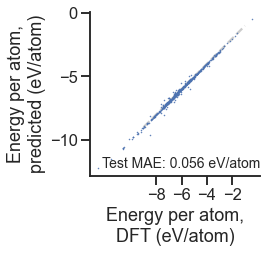

In [9]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(test.energyperatom, predictions, '.', ms=1)
ax.plot([-9, -1], [-9, -1], '--', color='.8', zorder=0)
ax.set_xticks([-2, -4, -6, -8])
plt.ylabel('Energy per atom,\npredicted (eV/atom)')
plt.xlabel('Energy per atom,\nDFT (eV/atom)')
plt.tight_layout()

ax.text(1., 0.025, f'Test MAE: {(test.energyperatom - predictions.squeeze()).abs().mean():.3f} eV/atom',
        ha='right', va='bottom', transform=ax.transAxes, fontsize=14)

sns.despine(trim=False)
# plt.savefig('figs/test_parity.svg')

In [10]:
test['predicted_energyperatom'] = predictions

In [11]:
# test.to_csv('trained_model2/predicted.csv', index=False)

Looks like we can speed up evaluation at test-time by not creating the primitive crystal. And good to validate that the predictions are (almost) identical between the two methods. Note, this changes the underlying graph structure as well

### Predict NREL MatDB data

In [12]:
import warnings

In [13]:
tqdm.pandas()

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [17]:
data2 = pd.read_csv('/projects/rlmolecule/pgorai/nrelmatdb_icsd2.csv')

cif_file = lambda x: '/projects/rlmolecule/pstjohn/utf8_cifs/icsd_{:06d}.cif.gz'.format(x)
get_crystal = lambda x: Structure.from_file(cif_file(x), primitive=True)

# Try to parse crystals with pymatgen
def get_crystal(icsd):
    try:
        return Structure.from_file(cif_file(icsd), primitive=True)
    except Exception:
        return None

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data2['crystal'] = data2.icsdnum.progress_apply(get_crystal)

data2 = data2.dropna(subset=['crystal'])

100%|██████████| 3889/3889 [01:27<00:00, 44.22it/s]


In [21]:
def matdb_gen():
    for crystal in tqdm(data2.crystal):
        yield preprocessor.construct_feature_matrices(crystal, train=False)
    
matdb_dataset = tf.data.Dataset.from_generator(
    matdb_gen,
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128,
                  padded_shapes=preprocessor.padded_shapes(max_sites=256, max_bonds=2048),
                  padding_values=preprocessor.padding_values)

In [22]:
predictions_matdb = model.predict(matdb_dataset)

100%|██████████| 3886/3886 [01:29<00:00, 43.45it/s]


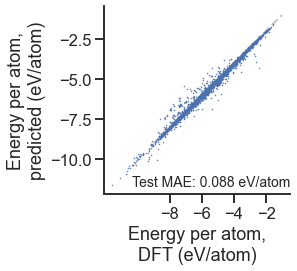

In [25]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(data2.energyperatom, predictions_matdb, '.', ms=1)
ax.plot([-9, -1], [-9, -1], '--', color='.8', zorder=0)
ax.set_xticks([-2, -4, -6, -8])
plt.ylabel('Energy per atom,\npredicted (eV/atom)')
plt.xlabel('Energy per atom,\nDFT (eV/atom)')
plt.tight_layout()

ax.text(1., 0.025, f'Test MAE: {(data2.energyperatom - predictions_matdb.squeeze()).abs().mean():.3f} eV/atom',
        ha='right', va='bottom', transform=ax.transAxes, fontsize=14)

sns.despine(trim=False)
# plt.savefig('figs/test_parity.svg')

In [26]:
data1 = pd.read_csv('/projects/rlmolecule/pgorai/nrelmatdb_icsd.csv')

cif_file = lambda x: '/projects/rlmolecule/pstjohn/utf8_cifs/icsd_{:06d}.cif.gz'.format(x)
get_crystal = lambda x: Structure.from_file(cif_file(x), primitive=True)

# Try to parse crystals with pymatgen
def get_crystal(icsd):
    try:
        return Structure.from_file(cif_file(icsd), primitive=True)
    except Exception:
        return None

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data1['crystal'] = data1.icsdnum.progress_apply(get_crystal)

data1 = data1.dropna(subset=['crystal'])

In [27]:
def matdb_gen():
    for crystal in tqdm(data1.crystal):
        yield preprocessor.construct_feature_matrices(crystal, train=False)
    
matdb_dataset = tf.data.Dataset.from_generator(
    matdb_gen,
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128,
                  padded_shapes=preprocessor.padded_shapes(max_sites=256, max_bonds=2048),
                  padding_values=preprocessor.padding_values)

predictions_matdb = model.predict(matdb_dataset)


100%|██████████| 22865/22865 [08:22<00:00, 45.49it/s]


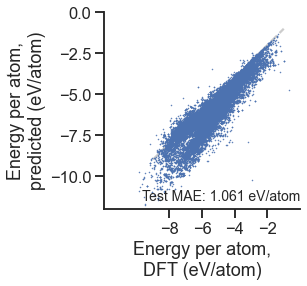

In [36]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(data1.energyperatom, predictions_matdb, '.', ms=1)
ax.plot([-9, -1], [-9, -1], '--', color='.8', zorder=0)
ax.set_xticks([-2, -4, -6, -8])
plt.ylabel('Energy per atom,\npredicted (eV/atom)')
plt.xlabel('Energy per atom,\nDFT (eV/atom)')
plt.tight_layout()
plt.ylim([-12, 0])
plt.xlim([-12, 0])

ax.text(1., 0.025, f'Test MAE: {(data1.energyperatom - predictions_matdb.squeeze()).abs().mean():.3f} eV/atom',
        ha='right', va='bottom', transform=ax.transAxes, fontsize=14)

sns.despine(trim=False)
# plt.savefig('figs/test_parity.svg')